In [1]:
import sys
sys.path.append("/Users/admin/Desktop/diploma")

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from scipy.optimize import minimize
from runc import RuncDualizer
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1, BoostingElementaryPredicatesv2
from utilites import preprocess
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
# from sklearn.datasets import load_boston
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RepeatedKFold
from scipy.optimize import minimize
import numpy.ma as mask
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample, check_random_state
from models import BoostingElementaryPredicates, BoostingElementaryPredicates1
import time
from tqdm import tqdm
from math import sqrt
import math
import itertools
from sklearn.datasets import load_diabetes
from sklearn.datasets import make_regression
import numpy as np
from sklearn.metrics import mean_squared_error
from joblib import Parallel, delayed
from own_forest import *
from utilites import *
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from memory_profiler import profile

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [1]:
import gc

gc.collect()

31

## Алгоритм бэггинга над бустингом эл.кл.

In [22]:
class BaggingElementaryTrees(BaseEstimator, RegressorMixin):
    def __init__(self, base_estimator=None, n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, bootstrap=True, bootstrap_features=True, n_jobs=None, random_state=None):
        self.base_estimator = base_estimator if base_estimator is not None else BoostingElementaryPredicates()
        self.base_params = base_estimator.get_params() if base_estimator is not None else {}
        print(self.base_params)
        self.n_estimators = n_estimators
        self.sub_sample_size = sub_sample_size
        self.sub_feature_size = sub_feature_size
        self.bootstrap = bootstrap
        self.bootstrap_features = bootstrap_features
        self.n_jobs = n_jobs
        self.random_state = random_state

    def fit(self, X, y):
        self.random_state_ = np.random.RandomState(self.random_state)
        seeds = self.random_state_.randint(np.iinfo(np.int32).max, size=self.n_estimators)

        self.estimators_ = []
        self.estimators_features_ = []

        if self.n_jobs is None:
            for seed in seeds:
                estimator, features = self._fit_estimator(X, y, seed)
                self.estimators_.append(estimator)
                self.estimators_features_.append(features)
        else:
            results = Parallel(n_jobs=self.n_jobs)(delayed(self._fit_estimator)(X, y, seed) for seed in seeds)
            self.estimators_, self.estimators_features_ = zip(*results)

        return self

    def _fit_estimator(self, X, y, seed):
        rng = np.random.default_rng(seed)
        samples = generate_bagging_indices(rng, X.shape[0], self.sub_sample_size, self.bootstrap)
        if self.bootstrap_features:
            features = generate_bagging_indices(rng, X.shape[1], self.sub_feature_size, self.bootstrap)
        else:
            features = np.arange(X.shape[1])

        estimator = self.base_estimator.__class__(**self.base_params)
        estimator.fit(X[samples][:, features], y[samples])
        
        return estimator, features

    def predict(self, X):
        predictions = np.mean([est.predict(X[:, features]) for est, features in zip(self.estimators_, self.estimators_features_)], axis=0)
        return predictions

## Подготовка данных

### Auto-MPG

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(dataset, 'MPG')

In [4]:
X_train.shape

(318, 7)

## Обучение и подбор параметров бустинга

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)  # sample indices of datasets for 5-fold cv

cv_sets = []
for train_index, test_index in kf.split(X_train):
    cv_sets.append(
        (
            X_train[train_index],
            y_train[train_index],
            X_train[test_index],
            y_train[test_index],
        )
    )  # construct 5-fold cv datasets

In [8]:
from itertools import product

lb_params =  {
    "num_iter" : np.linspace(1, 10, 10).astype(int),
    "m" : np.linspace(5, 59, 20).astype(int),
}

param_combinations = list(product(lb_params["num_iter"], lb_params["m"]))

In [12]:
import logging
import cProfile
import pstats

In [13]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [14]:
def evaluate_combinations():
    for num_iter, m in param_combinations:
        try:
            logging.info(f'Starting evaluation with num_iter={num_iter}, m={m}')
            cv_results = []
            regressor = BoostingElementaryPredicates(num_iter=num_iter, m=m, max_cov=500)
            for x_tr, y_tr, x_te, y_te in cv_sets:
                regressor.fit(x_tr, y_tr)
                cv_results.append(mean_squared_error(regressor.predict(x_te), y_te, squared=False))
            mean_cv_score = np.mean(cv_results)
            logging.info(f'Finished evaluation with num_iter={num_iter}, m={m}, mean_cv_score={mean_cv_score}')
        except Exception as e:
            # Логируем исключение, если что-то пошло не так
            logging.error(f'Error during evaluation with num_iter={num_iter}, m={m}: {e}')
            continue

In [15]:
pr = cProfile.Profile()
pr.enable()

evaluate_combinations()


pr.disable()
stats = pstats.Stats(pr).sort_stats('cumulative')
stats.print_stats()

2024-03-14 02:33:56,812 - INFO - Starting evaluation with num_iter=1, m=5
2024-03-14 02:33:56,873 - INFO - Finished evaluation with num_iter=1, m=5, mean_cv_score=8.136484736754557
2024-03-14 02:33:56,875 - INFO - Starting evaluation with num_iter=1, m=7
2024-03-14 02:33:56,931 - INFO - Finished evaluation with num_iter=1, m=7, mean_cv_score=8.263589885636902
2024-03-14 02:33:56,932 - INFO - Starting evaluation with num_iter=1, m=10
2024-03-14 02:33:56,991 - INFO - Finished evaluation with num_iter=1, m=10, mean_cv_score=8.158712524779553
2024-03-14 02:33:56,992 - INFO - Starting evaluation with num_iter=1, m=13
2024-03-14 02:33:57,052 - INFO - Finished evaluation with num_iter=1, m=13, mean_cv_score=9.170859215952575
2024-03-14 02:33:57,053 - INFO - Starting evaluation with num_iter=1, m=16
2024-03-14 02:33:57,115 - INFO - Finished evaluation with num_iter=1, m=16, mean_cv_score=9.170859215952575
2024-03-14 02:33:57,116 - INFO - Starting evaluation with num_iter=1, m=19
2024-03-14 02:

         32157564 function calls (29840972 primitive calls) in 78.972 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   78.972   39.486 /Users/admin/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3490(run_code)
        2    0.000    0.000   78.972   39.486 {built-in method builtins.exec}
        1    0.032    0.032   78.972   78.972 /var/folders/6n/8jjs7_ks1vvgsv0l2n5mxvdw0000gn/T/ipykernel_25529/1722631524.py:1(evaluate_combinations)
     1000    9.101    0.009   71.548    0.072 /Users/admin/Desktop/diploma/models.py:23(fit)
3433658/1117066    6.135    0.000   46.840    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
   272600    0.447    0.000   39.014    0.000 <__array_function__ internals>:177(isin)
   272600    0.848    0.000   38.150    0.000 /Users/admin/anaconda3/lib/python3.11/site-packages/numpy/lib/arraysetops.py:766(isin)
   272

In [5]:
def rmse(y1, y2):
    return np.mean((y1-y2)**2)**0.5

In [6]:
# Hp tuning with Sklearn

regressor = BoostingElementaryPredicatesv2(max_cov=500)

lb_params =  {
    "num_iter" : np.linspace(50, 600, 10).astype(int),
    "m" : np.linspace(5, 20, 4).astype(int),
    "max_cov": [500],
    'learning_rate': [0.1, 0.5, 0.9]
}


scoring_fnc = make_scorer(rmse, greater_is_better=False)

grid_search = RandomizedSearchCV(
    estimator=regressor, param_distributions=lb_params, scoring=scoring_fnc, cv=5
)

grid_search = grid_search.fit(X_train, y_train)

Early stopping triggered after 14 iterations with validation loss 55.1528
Early stopping triggered after 22 iterations with validation loss 61.6173
Early stopping triggered after 11 iterations with validation loss 66.8555
Early stopping triggered after 11 iterations with validation loss 75.5479
Early stopping triggered after 11 iterations with validation loss 79.6302
Early stopping triggered after 25 iterations with validation loss 31.8720
Early stopping triggered after 42 iterations with validation loss 55.4149
Early stopping triggered after 11 iterations with validation loss 66.8555
Early stopping triggered after 14 iterations with validation loss 78.6940
Early stopping triggered after 15 iterations with validation loss 65.7729
Early stopping triggered after 22 iterations with validation loss 37.7213
Early stopping triggered after 20 iterations with validation loss 75.1575
Early stopping triggered after 11 iterations with validation loss 46.5995
Early stopping triggered after 23 iter

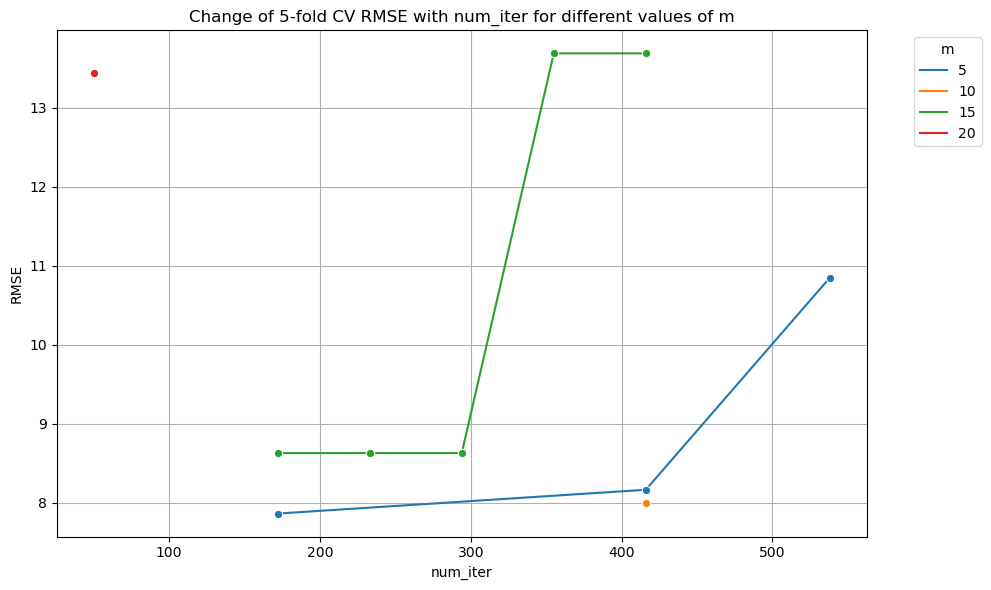

In [7]:
cvres = grid_search.cv_results_

data = []
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    num_iter = params['num_iter']
    m = params['m']
    data.append({"num_iter": num_iter, "m": m, "RMSE": -mean_score})


df = pd.DataFrame(data)

# Строим график
plt.figure(figsize=(10, 6))  
sns.lineplot(data=df, x="num_iter", y="RMSE", hue="m", palette="tab10", marker="o")

plt.title("Change of 5-fold CV RMSE with num_iter for different values of m")
plt.xlabel("num_iter")
plt.ylabel("RMSE")

# Управление легендой вне области графика
plt.legend(title="m", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

## Лучшая модель

In [6]:
grid_search.best_params_
best_regressor = grid_search.best_estimator_

# Produce the value for 'max_depth'
print("Best hyperparameters is {}.".format(grid_search.best_params_))

# Model prediction on training & test data
y_pred_train = best_regressor.predict(X_train)
y_pred_test = best_regressor.predict(X_test)

print("\n--Train RMSE--\n{}".format(mean_squared_error(y_train, y_pred_train, squared=False)))

print("\n--Test RMSE--\n{}\n".format(mean_squared_error(y_test, y_pred_test, squared=False)))

print(r2_score(y_test, y_pred_test))

Best hyperparameters is {'m': 17, 'num_iter': 10}.

--Train RMSE--
3.507212819983054

--Test RMSE--
3.640553593897094

0.7150458166537339


## Кривая на тесте V.S. Кривая на валидации

Number of iters: 1, Test MSE: 5.386544983428773
Number of iters: 2, Test MSE: 4.6157808820326105
Number of iters: 3, Test MSE: 4.288930235421998
Number of iters: 4, Test MSE: 4.043265556615753
Number of iters: 5, Test MSE: 4.060866714310607
Number of iters: 6, Test MSE: 3.931860034597472
Number of iters: 7, Test MSE: 3.663887546548932
Number of iters: 8, Test MSE: 3.7121232662119077
Number of iters: 9, Test MSE: 3.6200383340931004
Number of iters: 10, Test MSE: 3.640553593897094


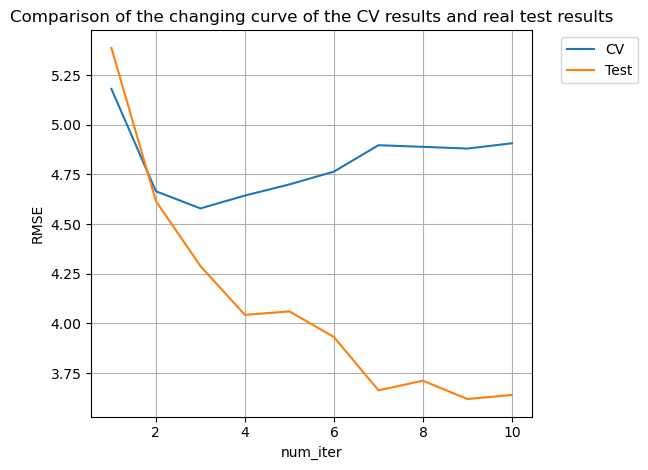

In [7]:
test_results = []
for num_iter in lb_params["num_iter"]:
    tmp_results = []
    regressor = BoostingElementaryPredicatesv2(num_iter=num_iter, m=grid_search.best_params_['m'], max_cov=500)
    regressor.fit(X_train, y_train)
    test_results.append(mean_squared_error(regressor.predict(X_test), y_test, squared=False))
    print("Number of iters: {}, Test MSE: {}".format(num_iter, test_results[-1]))

cv_res = [-cvres["mean_test_score"][i*len(lb_params['num_iter'])+np.where(lb_params['m'] == grid_search.best_params_['m'])[0][0]] for i in range(10)]

plt.plot(lb_params["num_iter"], cv_res)
plt.plot(lb_params["num_iter"], test_results)
plt.title("Comparison of the changing curve of the CV results and real test results")
plt.legend(["CV", "Test"],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("num_iter")
plt.ylabel("RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()


11


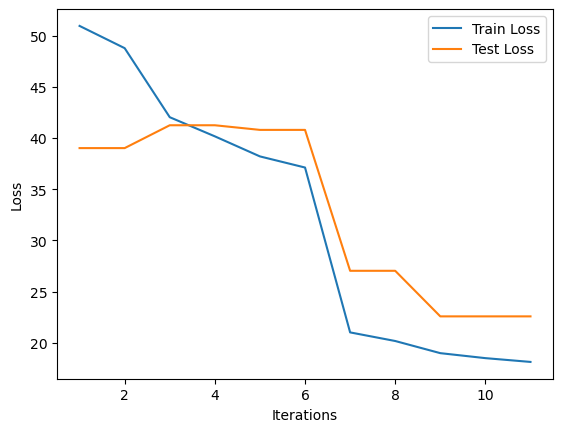

BoostingElementaryPredicates:
Root Mean Squared Error: 4.752959942792952
R2 Score: 0.5142995702472819


In [8]:
model = BoostingElementaryPredicates1(num_iter=11, m=59) # критическое значение
model.fit_predict(X_train, y_train, X_test, y_test)
y_pred = model.predict(X_test)
print("BoostingElementaryPredicates:")
print("Root Mean Squared Error:", mean_squared_error(y_test, y_pred, squared=False))
print("R2 Score:", r2_score(y_test, y_pred))

## Кросс-валидация бустинга на  небольших m $\in [10,20]$

In [10]:
regressor = BoostingElementaryPredicatesv2(max_cov=500)

lb_params =  {
    "num_iter" : np.linspace(1, 100, 20).astype(int),
    "m" : np.linspace(10, 20, 10).astype(int),
    "max_cov": [100, 500, 1000]
}


scoring_fnc = make_scorer(rmse, greater_is_better=False)

grid_search = GridSearchCV(
    estimator=regressor, param_grid=lb_params, scoring=scoring_fnc, cv=5
)

grid_search = grid_search.fit(X_train, y_train)

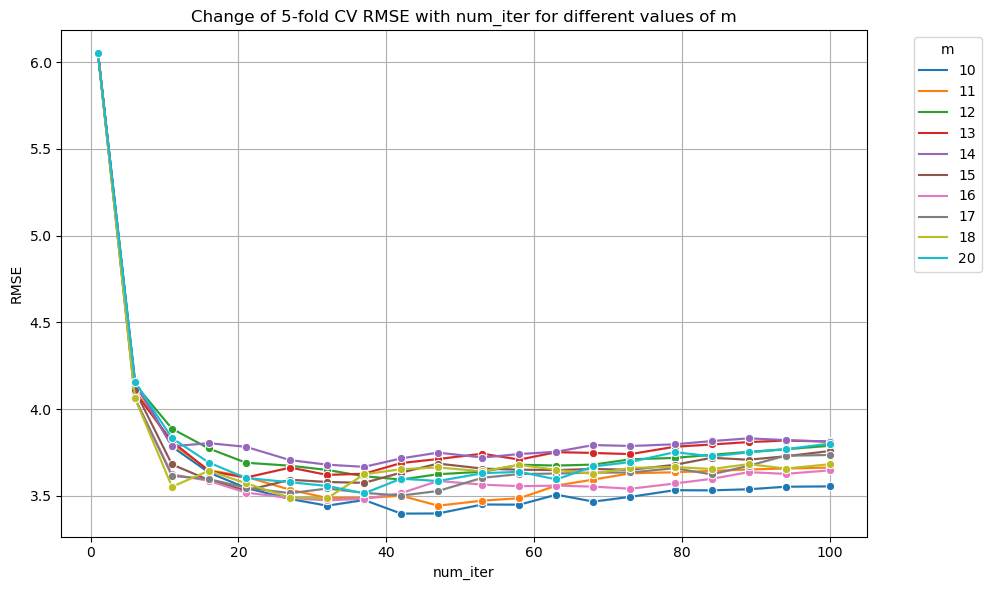

In [11]:
cvres = grid_search.cv_results_

data = []
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    num_iter = params['num_iter']
    m = params['m']
    data.append({"num_iter": num_iter, "m": m, "RMSE": -mean_score})


df = pd.DataFrame(data)

# Строим график
plt.figure(figsize=(10, 6))  
sns.lineplot(data=df, x="num_iter", y="RMSE", hue="m", palette="tab10", marker="o")

plt.title("Change of 5-fold CV RMSE with num_iter for different values of m")
plt.xlabel("num_iter")
plt.ylabel("RMSE")

# Управление легендой вне области графика
plt.legend(title="m", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
grid_search.best_params_
best_regressor = grid_search.best_estimator_

# Produce the value for 'max_depth'
print("Best hyperparameters is {}.".format(grid_search.best_params_))

# Model prediction on training & test data
y_pred_train = best_regressor.predict(X_train)
y_pred_test = best_regressor.predict(X_test)

print("\n--Train RMSE--\n{}".format(mean_squared_error(y_train, y_pred_train, squared=False)))

print("\n--Test RMSE--\n{}\n".format(mean_squared_error(y_test, y_pred_test, squared=False)))


Best hyperparameters is {'m': 10, 'max_cov': 100, 'num_iter': 42}.

--Train RMSE--
2.371675686504322

--Test RMSE--
2.8788855080073046



Number of iters: 1, Test RMSE: 5.386544983428773, Test R2: 0.37617789259655743
Number of iters: 6, Test RMSE: 3.5792837098970693, Test R2: 0.7245565640835536
Number of iters: 11, Test RMSE: 3.1977166854039063, Test R2: 0.7801532015417056
Number of iters: 16, Test RMSE: 2.7901461660543596, Test R2: 0.8326236512933908
Number of iters: 21, Test RMSE: 2.6706950590396965, Test R2: 0.8466482327076968
Number of iters: 27, Test RMSE: 2.7894235463508714, Test R2: 0.8327103376373546
Number of iters: 32, Test RMSE: 2.543222615785975, Test R2: 0.8609378520217348
Number of iters: 37, Test RMSE: 2.5474805039155792, Test R2: 0.860471823822283
Number of iters: 42, Test RMSE: 2.8788855080073046, Test R2: 0.8218076864531974
Number of iters: 47, Test RMSE: 2.8359519823051733, Test R2: 0.8270829069686609
Number of iters: 53, Test RMSE: 2.744742916197206, Test R2: 0.8380266646525083
Number of iters: 58, Test RMSE: 3.01371726424125, Test R2: 0.8047256542367434
Number of iters: 63, Test RMSE: 2.9998883170044

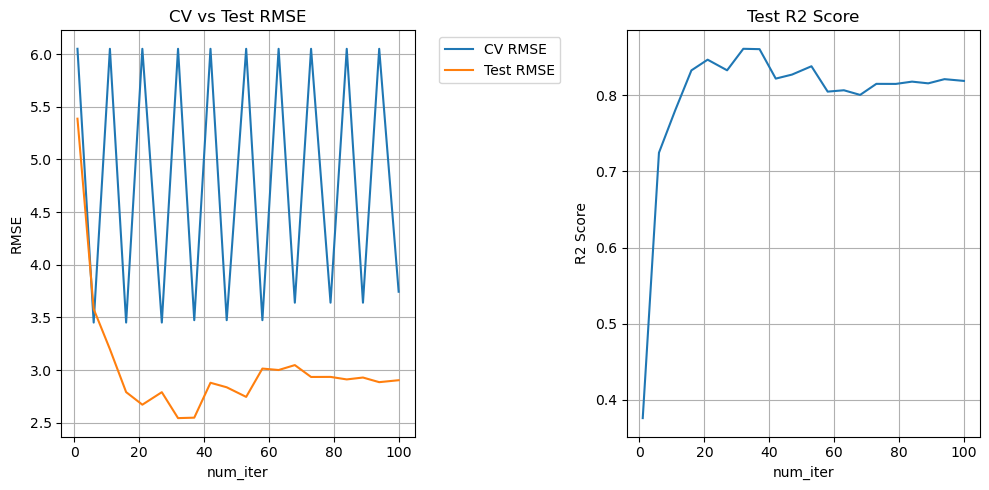

In [21]:
# test_results = []
# for num_iter in lb_params["num_iter"]:
#     tmp_results = []
#     regressor = BoostingElementaryPredicatesv2(num_iter=num_iter, m=grid_search.best_params_['m'], max_cov=100)
#     regressor.fit(X_train, y_train)
#     test_results.append(mean_squared_error(regressor.predict(X_test), y_test, squared=False))
#     print("Number of iters: {}, Test RMSE: {}".format(num_iter, test_results[-1]))

# cv_res = [-cvres["mean_test_score"][i*len(lb_params['m'])+np.where(lb_params['m'] == grid_search.best_params_['m'])[0][0]] for i in range(20)]

# plt.plot(lb_params["num_iter"], cv_res)
# plt.plot(lb_params["num_iter"], test_results)
# plt.title("Comparison of the changing curve of the CV results and real test results")
# plt.legend(["CV", "Test"],  bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.xlabel("num_iter")
# plt.ylabel("RMSE")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

test_results = []
r2_scores = []
for num_iter in lb_params["num_iter"]:
    tmp_results = []
    regressor = BoostingElementaryPredicatesv2(num_iter=num_iter, m=grid_search.best_params_['m'], max_cov=100)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    rmse = mean_squared_error(predictions, y_test, squared=False)
    r2 = r2_score(y_test, predictions)
    test_results.append(rmse)
    r2_scores.append(r2)
    print(f"Number of iters: {num_iter}, Test RMSE: {rmse}, Test R2: {r2}")

cv_res = [-cvres["mean_test_score"][i*len(lb_params['m']) + np.where(lb_params['m'] == grid_search.best_params_['m'])[0][0]] for i in range(20)]

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(lb_params["num_iter"], cv_res)
plt.plot(lb_params["num_iter"], test_results)
plt.title("CV vs Test RMSE")
plt.legend(["CV RMSE", "Test RMSE"],  bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("num_iter")
plt.ylabel("RMSE")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(lb_params["num_iter"], r2_scores)
plt.title("Test R2 Score")
plt.xlabel("num_iter")
plt.ylabel("R2 Score")
plt.grid(True)

plt.tight_layout()
plt.show()

## Зависимость качества от размера матрицы сравнения в бустинге

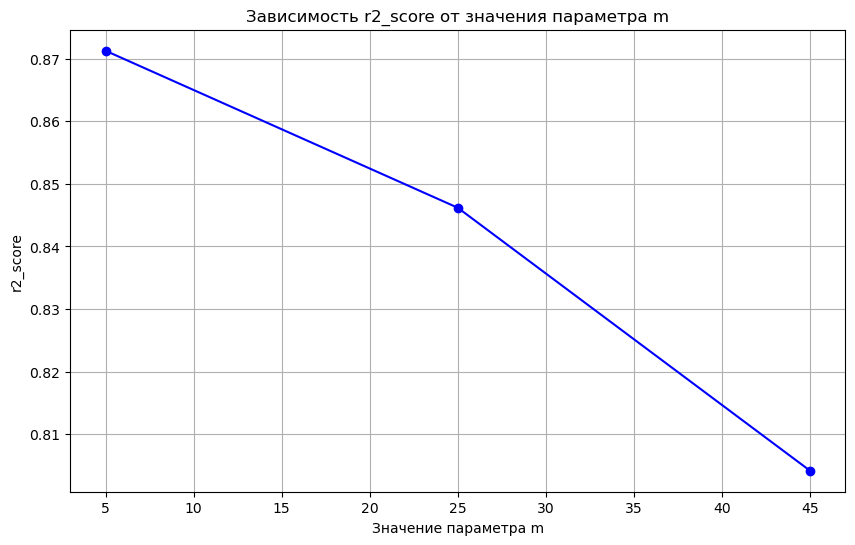

In [6]:
m_values = list(range(5, 60, 20))
r2_scores = []

for m in m_values:
    model = BoostingElementaryPredicatesv2(num_iter=32, m=m, max_cov=100)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    r2_scores.append(r2)

# Визуализация
plt.figure(figsize=(10, 6))
plt.plot(m_values, r2_scores, marker='o', linestyle='-', color='b')
plt.title('Зависимость r2_score от значения параметра m')
plt.xlabel('Значение параметра m')
plt.ylabel('r2_score')
plt.grid(True)
plt.show()

## Обучение и подбор параметров бэггинга

In [5]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

In [7]:
model = BaggingElementaryTrees(BoostingElementaryPredicatesv2(num_iter=32, m=10, max_cov=100), n_estimators=10, sub_sample_size=1.0, sub_feature_size=1.0, n_jobs=4)
rmse, r2_score = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=1.0, num_bags=10, num_iter=10, m=20)

print(f"Validation RMSE: {rmse}")
print(f"Validation R2: {r2_score}")

{'m': 10, 'max_cov': 100, 'num_iter': 32}
Validation RMSE: 3.8566912324195886
Validation R2: 0.7484935337695511


In [18]:
from sklearn.metrics import mean_squared_error, r2_score
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [19]:
n_estimators_list = np.arange(50, 1000, 100)  # Список значений для перебора
rmse_values = []  # Сюда будем сохранять значения RMSE
r2_values = []  # Сюда будем сохранять значения R2

for n_estimators in n_estimators_list:
    model = BaggingElementaryTrees(
        base_estimator=BoostingElementaryPredicatesv2(num_iter=32, m=10, max_cov=100),
        n_estimators=n_estimators,
        sub_sample_size=1.0,
        sub_feature_size=1.0,
        n_jobs=4,
        random_state=42
    )

    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    current_rmse = mean_squared_error(y_val, predictions, squared=False)
    current_r2 = r2_score(y_val, predictions)

    rmse_values.append(current_rmse)
    r2_values.append(current_r2)

    print(f"n_estimators: {n_estimators}, RMSE: {current_rmse}, R2: {current_r2}")

# График RMSE в зависимости от количества деревьев
plt.figure(figsize=(7, 5))
plt.plot(n_estimators_list, rmse_values, marker='o', linestyle='-')
plt.title('Зависимость RMSE от числа моделей в бэггинге')
plt.xlabel('Количество деревьев')
plt.ylabel('RMSE')
plt.grid(True)
plt.savefig('rmse_plot.png')  # Сохраняем график RMSE
plt.close()

# График R2 в зависимости от количества деревьев
plt.figure(figsize=(7, 5))
plt.plot(n_estimators_list, r2_values, marker='o', linestyle='-', color='red')
plt.title('Зависимость R2 от числа моделей в бэггинге')
plt.xlabel('Количество деревьев')
plt.ylabel('R2')
plt.grid(True)
plt.savefig('r2_plot.png')  # Сохраняем график R2
plt.close()

{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 50, RMSE: 4.042869276813693, R2: 0.7236249640360555
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 150, RMSE: 3.9046460490725043, R2: 0.7422000921790952
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 250, RMSE: 3.846500746740908, R2: 0.749820882438449
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 350, RMSE: 3.8559604525933913, R2: 0.7485888374521392
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 450, RMSE: 3.835701210095094, R2: 0.7512237292737226
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 550, RMSE: 3.8726844766263073, R2: 0.7464032733315007
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 650, RMSE: 3.870767206097918, R2: 0.7466543101391263
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 750, RMSE: 3.888814180989794, R2: 0.7442864168815415
{'m': 10, 'max_cov': 100, 'num_iter': 32}
n_estimators: 850, RMSE: 3.876190712478792, R2: 0.7459438646411838
{'m': 10, 'max_cov

##  Эксперименты с различными долями признаков

BoostingElementaryPredicates(m=40, num_iter=11)


BoostingElementaryPredicates(m=40, num_iter=11)
BoostingElementaryPredicates(m=40, num_iter=11)
BoostingElementaryPredicates(m=40, num_iter=11)
BoostingElementaryPredicates(m=40, num_iter=11)


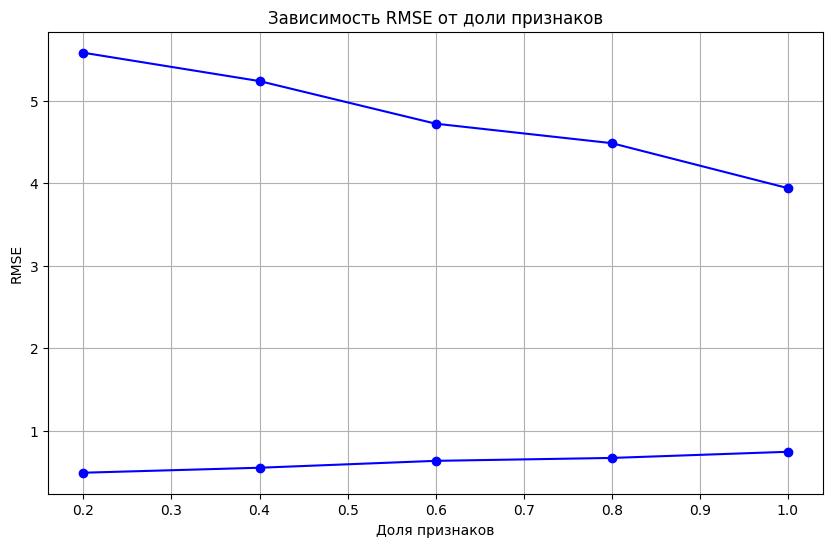

In [15]:
fracs = np.linspace(0.2, 1.0, 5)  # Диапазон долей признаков
rmses = []  # Список для хранения результатов

for frac in fracs:
    model = BaggingElementaryTrees(BoostingElementaryPredicates(num_iter=11, m=40), n_estimators=10, sub_feature_size=frac, bootstrap=True, bootstrap_features=True, n_jobs=40, random_state=42)
    rmse = train_and_validate(model, X_train, y_train, X_val, y_val, fraction=frac, num_bags=10, num_iter=10, m=20)
    rmses.append(rmse)

# Отрисовка графиков
plt.figure(figsize=(10, 6))
plt.plot(fracs, rmses, marker='o', linestyle='-', color='b')
plt.title('Зависимость RMSE от доли признаков')
plt.xlabel('Доля признаков')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [12]:
rmse

3.8566912324195886